<a href="https://www.kaggle.com/code/habibulbasher01644/drug-review-dataset-sentiment-analysis?scriptVersionId=225509284" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [40]:

# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drugreview/drug_review_train.csv
/kaggle/input/drugreview/drug_review_test.csv
/kaggle/input/drugreview/drug_review_test.jsonl
/kaggle/input/drugreview/drug_review_train.jsonl
/kaggle/input/drugreview/drugsComTest_raw.tsv
/kaggle/input/drugreview/drugsComTrain_raw.tsv
/kaggle/input/drugreview/drug_review_validation.jsonl
/kaggle/input/drugreview/drug_review_validation.csv
/kaggle/input/drugreview/drug_review/dataset_dict.json
/kaggle/input/drugreview/drug_review/validation/state.json
/kaggle/input/drugreview/drug_review/validation/dataset_info.json
/kaggle/input/drugreview/drug_review/validation/dataset.arrow
/kaggle/input/drugreview/drug_review/test/state.json
/kaggle/input/drugreview/drug_review/test/dataset_info.json
/kaggle/input/drugreview/drug_review/test/dataset.arrow
/kaggle/input/drugreview/drug_review/train/state.json
/kaggle/input/drugreview/drug_review/train/dataset_info.json
/kaggle/input/drugreview/drug_review/train/dataset.arrow
/kaggle/input/drugreview/dru

In [41]:
import re
import string
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:

train_df = pd.read_csv('/kaggle/input/drugreview/drug_review_train.csv')
val_df = pd.read_csv('/kaggle/input/drugreview/drug_review_validation.csv')
test_df = pd.read_csv('/kaggle/input/drugreview/drug_review_test.csv')

In [43]:
train_df.head(15)

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74
5,5,218554,Tri-Sprintec,birth control,"""used for birth control and period issues- ver...",2.0,"January 7, 2017",4,57
6,6,207442,Suprep Bowel Prep Kit,bowel preparation,"""my prep instructions were one 6oz bottle the ...",8.0,"December 5, 2016",18,86
7,7,63753,Epiduo,acne,"""love it. i had the worst breakouts, so i got ...",9.0,"October 19, 2011",20,63
8,8,140845,Escitalopram,depression,"""i felt a positive difference within the first...",9.0,"April 21, 2016",13,49
9,9,182520,Mirena,birth control,"""i have been on mirena for over a year now and...",1.0,"June 15, 2009",45,37


In [45]:

# Select only the 'review' and 'rating' columns
train_df = train_df[['review', 'rating']]
val_df = val_df[['review', 'rating']]
test_df = test_df[['review', 'rating']]

In [46]:
train_df.head(25)

,review,rating
0,"""i have used restasis for about a year now and...",2.0
1,"""my experience has been somewhat mixed. i have...",7.0
2,"""this is my second implanon would not recommen...",1.0
3,"""i recommend taking as prescribed, and the bot...",10.0
4,"""i have been on ampyra for 5 days and have bee...",9.0
5,"""used for birth control and period issues- ver...",2.0
6,"""my prep instructions were one 6oz bottle the ...",8.0
7,"""love it. i had the worst breakouts, so i got ...",9.0
8,"""i felt a positive difference within the first...",9.0
9,"""i have been on mirena for over a year now and...",1.0


In [47]:

print(train_df.info())
print(val_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110811 entries, 0 to 110810
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   review  110811 non-null  object 
 1   rating  110811 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27703 entries, 0 to 27702
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  27703 non-null  object 
 1   rating  27703 non-null  float64
dtypes: float64(1), object(1)
memory usage: 433.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46108 entries, 0 to 46107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   review  46108 non-null  object 
 1   rating  46108 non-null  float64
dtypes: float64(1), object(1)
memory usage: 720.6+ KB
None


In [48]:
print(train_df.isnull().sum())
print(val_df.isnull().sum())
print(test_df.isnull().sum())

review    0
rating    0
dtype: int64
review    0
rating    0
dtype: int64
review    0
rating    0
dtype: int64


In [49]:


def sentiments_label(rating):
    if rating >= 7:
        return 'positive'
    elif rating >= 4:
        return 'neutral'
    else:
        return 'negative'

# Apply sentiment labeling (corrected)
train_df['sentiment'] = train_df['rating'].apply(sentiments_label)
val_df['sentiment'] = val_df['rating'].apply(sentiments_label)
test_df['sentiment'] = test_df['rating'].apply(sentiments_label)

In [50]:
print(train_df[['rating', 'sentiment']].head())

   rating sentiment
0     2.0  negative
1     7.0  positive
2     1.0  negative
3    10.0  positive
4     9.0  positive


In [51]:
train_df = train_df.drop('rating', axis=1)
val_df = val_df.drop('rating', axis=1)
test_df = test_df.drop('rating', axis=1)

In [52]:
train_df

train_df.head(10)

,review,sentiment
0,"""i have used restasis for about a year now and...",negative
1,"""my experience has been somewhat mixed. i have...",positive
2,"""this is my second implanon would not recommen...",negative
3,"""i recommend taking as prescribed, and the bot...",positive
4,"""i have been on ampyra for 5 days and have bee...",positive
5,"""used for birth control and period issues- ver...",negative
6,"""my prep instructions were one 6oz bottle the ...",positive
7,"""love it. i had the worst breakouts, so i got ...",positive
8,"""i felt a positive difference within the first...",positive
9,"""i have been on mirena for over a year now and...",negative


In [53]:
train_df.describe()

,review,sentiment
count,110811,110811
unique,84138,3
top,"""was on junel fe and it worked according to my...",positive
freq,4,73638


In [54]:

train_df['sentiment'].value_counts()

sentiment
positive    73638
negative    23602
neutral     13571
Name: count, dtype: int64

In [55]:

print(f"New dataset size: {train_df.shape}")

New dataset size: (110811, 2)


In [56]:

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [57]:


def normalize_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [58]:


def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [59]:

# def lemmatize_text(text):
#     lemmatizer = WordNetLemmatizer()
#     words = word_tokenize(text)
#     lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
#     return " ".join(lemmatized_words)

def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    return " ".join([ps.stem(word) for word in words])


In [60]:

def clean_text(text):
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [61]:

train_df['clean_review'] = train_df['review'].apply(clean_text)
val_df['clean_review'] = val_df['review'].apply(clean_text)
test_df['clean_review'] = test_df['review'].apply(clean_text)

print(train_df[['review', 'clean_review']].head())  # View sample cleaned data

                                              review  \
0  "i have used restasis for about a year now and...   
1  "my experience has been somewhat mixed. i have...   
2  "this is my second implanon would not recommen...   
3  "i recommend taking as prescribed, and the bot...   
4  "i have been on ampyra for 5 days and have bee...   

                                        clean_review  
0  use restasi year seen almost progress life red...  
1  experi somewhat mix use implanon nearli 14 mon...  
2  second implanon would recommend first one okay...  
3  recommend take prescrib bottl usual say take x...  
4  ampyra 5 day happi new pill first 2 day good s...  


In [62]:

# Label encoding
label_encoder = LabelEncoder()
train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment_encoded'] = label_encoder.transform(val_df['sentiment'])
test_df['sentiment_encoded'] = label_encoder.transform(test_df['sentiment'])
print("Label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


In [63]:

# Tokenization and padding
max_words = 10000
max_len = 150
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_review'])
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df['clean_review']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_df['clean_review']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df['clean_review']), maxlen=max_len)
y_train = train_df['sentiment_encoded'].values
y_val = val_df['sentiment_encoded'].values
y_test = test_df['sentiment_encoded'].values

In [64]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (110811, 150)
X_val shape: (27703, 150)
X_test shape: (46108, 150)


In [70]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model_rnn = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SimpleRNN(64),
    Dense(3, activation='softmax')
])
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.7193 - loss: 0.7178 - val_accuracy: 0.7611 - val_loss: 0.6168
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.7834 - loss: 0.5622 - val_accuracy: 0.7702 - val_loss: 0.6183
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8395 - loss: 0.4319 - val_accuracy: 0.7865 - val_loss: 0.5768
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.8796 - loss: 0.3324 - val_accuracy: 0.7964 - val_loss: 0.6007
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.9083 - loss: 0.2638 - val_accuracy: 0.8006 - val_loss: 0.6129
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.9284 - loss: 0.2121 - val_accuracy: 0.8131 - val_loss: 0.6365
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.9408 - loss: 0.1736 - val_accuracy: 0.7951 - val_loss: 0.7163
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.9470 -

In [69]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64),
    Dense(3, activation='softmax')
])
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.7390 - loss: 0.6637 - val_accuracy: 0.7730 - val_loss: 0.5796
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8007 - loss: 0.5053 - val_accuracy: 0.7840 - val_loss: 0.5593
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8403 - loss: 0.4148 - val_accuracy: 0.7969 - val_loss: 0.5395
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8733 - loss: 0.3388 - val_accuracy: 0.8090 - val_loss: 0.5436
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9037 - loss: 0.2639 - val_accuracy: 0.8108 - val_loss: 0.5522
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9278 - loss: 0.2051 - val_accuracy: 0.8246 - val_loss: 0.5885
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9467 - loss: 0.1555 - val_accuracy: 0.8349 - val_loss: 0.6393
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.9615 - loss: 0

In [68]:

from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dense(3, activation='softmax')
])
model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bilstm = model_bilstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.7434 - loss: 0.6567 - val_accuracy: 0.7685 - val_loss: 0.5850
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.7989 - loss: 0.5077 - val_accuracy: 0.7848 - val_loss: 0.5482
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.8368 - loss: 0.4204 - val_accuracy: 0.7943 - val_loss: 0.5383
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.8706 - loss: 0.3403 - val_accuracy: 0.7974 - val_loss: 0.5520
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9040 - loss: 0.2609 - val_accuracy: 0.8151 - val_loss: 0.5677
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9301 - loss: 0.1969 - val_accuracy: 0.8260 - val_loss: 0.5991
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9490 - loss: 0.1492 - val_accuracy: 0.8335 - val_loss: 0.6670
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.9638 -

In [71]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

model_attention = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    AttentionLayer(),
    Dense(3, activation='softmax')
])
model_attention.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_attention = model_attention.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.7326 - loss: 0.6867 - val_accuracy: 0.7729 - val_loss: 0.5699
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.8001 - loss: 0.5024 - val_accuracy: 0.7873 - val_loss: 0.5370
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.8351 - loss: 0.4213 - val_accuracy: 0.7971 - val_loss: 0.5273
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.8683 - loss: 0.3472 - val_accuracy: 0.8043 - val_loss: 0.5345
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 31s 8ms/step - accuracy: 0.8951 - loss: 0.2782 - val_accuracy: 0.8150 - val_loss: 0.5656
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.9204 - loss: 0.2168 - val_accuracy: 0.8244 - val_loss: 0.6034
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.9411 - loss: 0.1679 - val_accuracy: 0.8262 - val_loss: 0.6609
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.9540 - loss: 0

In [72]:
model_bilstm_attention = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    AttentionLayer(),
    Dense(3, activation='softmax')
])
model_bilstm_attention.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_bilstm_attention = model_bilstm_attention.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=30, verbose=1)

Epoch 1/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 52s 14ms/step - accuracy: 0.7353 - loss: 0.6770 - val_accuracy: 0.7748 - val_loss: 0.5611
Epoch 2/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.8032 - loss: 0.4960 - val_accuracy: 0.7877 - val_loss: 0.5337
Epoch 3/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.8400 - loss: 0.4132 - val_accuracy: 0.7986 - val_loss: 0.5237
Epoch 4/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.8720 - loss: 0.3376 - val_accuracy: 0.8062 - val_loss: 0.5496
Epoch 5/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9043 - loss: 0.2604 - val_accuracy: 0.8169 - val_loss: 0.5650
Epoch 6/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9279 - loss: 0.2015 - val_accuracy: 0.8282 - val_loss: 0.5867
Epoch 7/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - accuracy: 0.9469 - loss: 0.1523 - val_accuracy: 0.8292 - val_loss: 0.6643
Epoch 8/15
3694/3694 ━━━━━━━━━━━━━━━━━━━━ 50s 13ms/step - accuracy: 0.9594 -

In [73]:


val_loss_rnn, val_acc_rnn = model_rnn.evaluate(X_val, y_val, verbose=0)
test_loss_rnn, test_acc_rnn = model_rnn.evaluate(X_test, y_test, verbose=0)
print(f"RNN - Val Acc: {val_acc_rnn:.4f}, Test Acc: {test_acc_rnn:.4f}")

val_loss_lstm, val_acc_lstm = model_lstm.evaluate(X_val, y_val, verbose=0)
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"LSTM - Val Acc: {val_acc_lstm:.4f}, Test Acc: {test_acc_lstm:.4f}")

val_loss_bilstm, val_acc_bilstm = model_bilstm.evaluate(X_val, y_val, verbose=0)
test_loss_bilstm, test_acc_bilstm = model_bilstm.evaluate(X_test, y_test, verbose=0)
print(f"BiLSTM - Val Acc: {val_acc_bilstm:.4f}, Test Acc: {test_acc_bilstm:.4f}")

val_loss_attention, val_acc_attention = model_attention.evaluate(X_val, y_val, verbose=0)
test_loss_attention, test_acc_attention = model_attention.evaluate(X_test, y_test, verbose=0)
print(f"Attention - Val Acc: {val_acc_attention:.4f}, Test Acc: {test_acc_attention:.4f}")

val_loss_bilstm_att, val_acc_bilstm_att = model_bilstm_attention.evaluate(X_val, y_val, verbose=0)
test_loss_bilstm_att, test_acc_bilstm_att = model_bilstm_attention.evaluate(X_test, y_test, verbose=0)
print(f"BiLSTM+Attention - Val Acc: {val_acc_bilstm_att:.4f}, Test Acc: {test_acc_bilstm_att:.4f}")



RNN - Val Acc: 0.8124, Test Acc: 0.8125
LSTM - Val Acc: 0.8467, Test Acc: 0.8485
BiLSTM - Val Acc: 0.8466, Test Acc: 0.8465
Attention - Val Acc: 0.8489, Test Acc: 0.8484
BiLSTM+Attention - Val Acc: 0.8471, Test Acc: 0.8466


1441/1441 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1441/1441 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


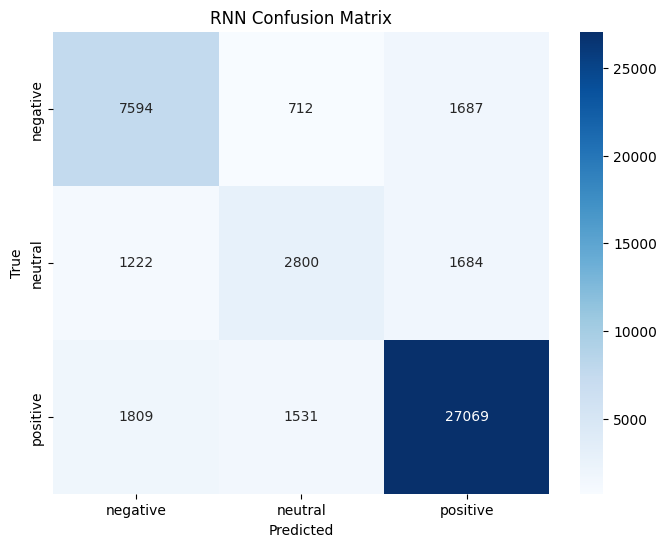

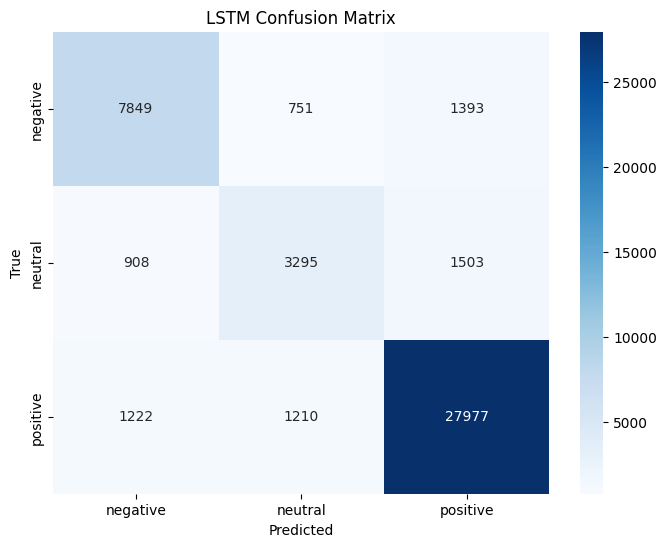

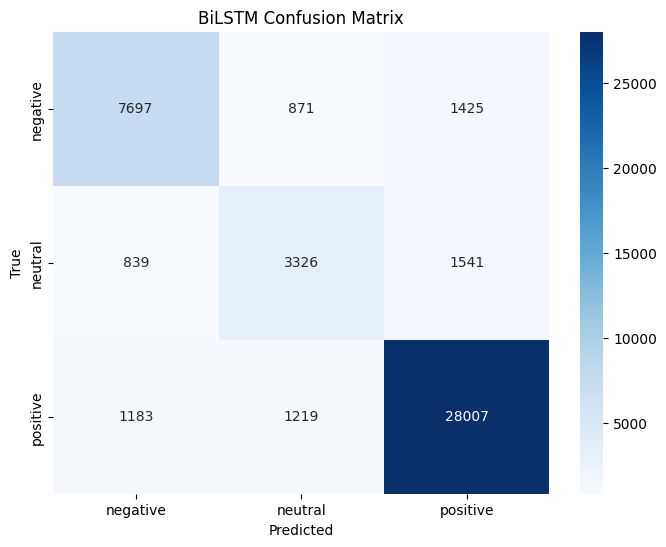

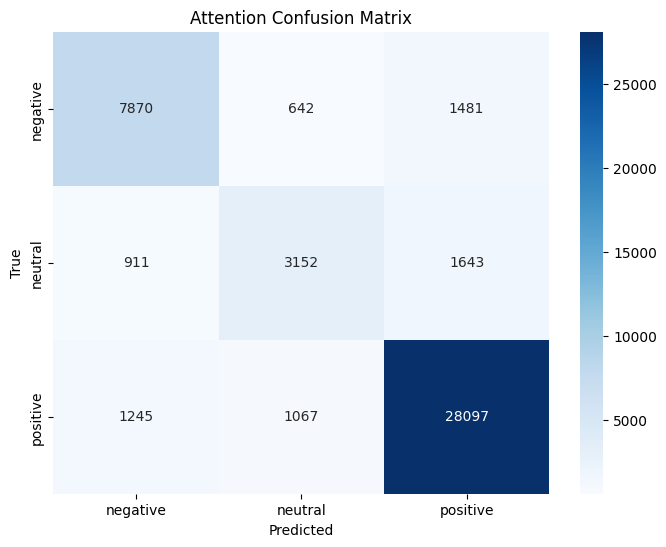

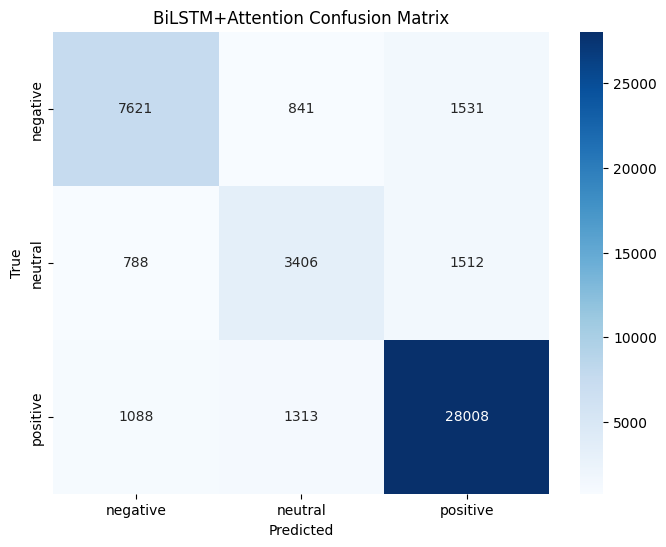

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_pred_rnn = np.argmax(model_rnn.predict(X_test), axis=1)
y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test), axis=1)
y_pred_attention = np.argmax(model_attention.predict(X_test), axis=1)
y_pred_bilstm_att = np.argmax(model_bilstm_attention.predict(X_test), axis=1)

plot_confusion_matrix(y_test, y_pred_rnn, 'RNN Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_lstm, 'LSTM Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_bilstm, 'BiLSTM Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_attention, 'Attention Confusion Matrix')
plot_confusion_matrix(y_test, y_pred_bilstm_att, 'BiLSTM+Attention Confusion Matrix')


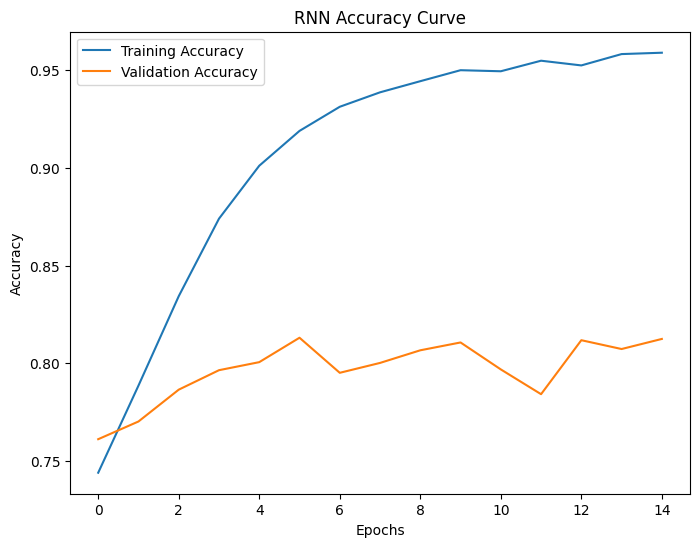

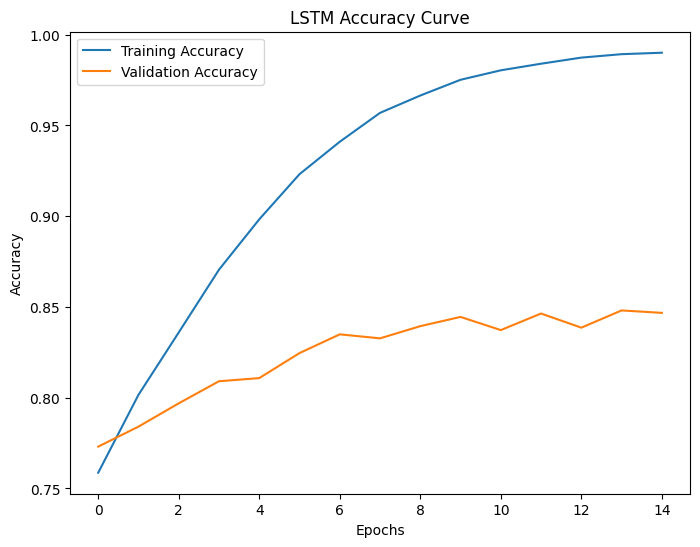

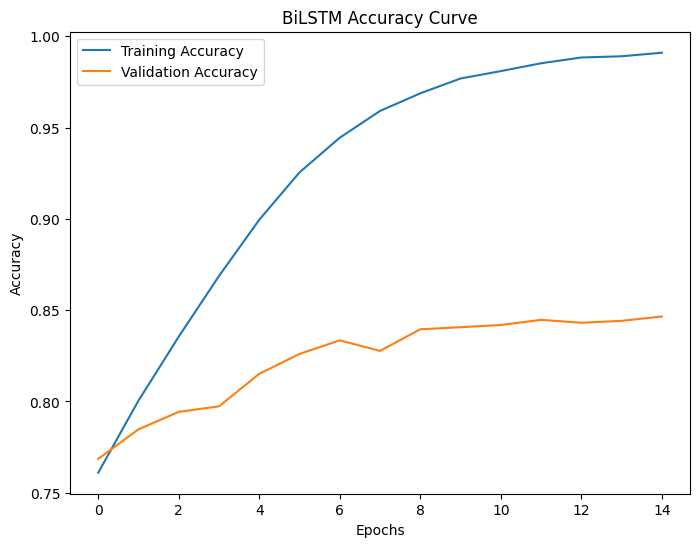

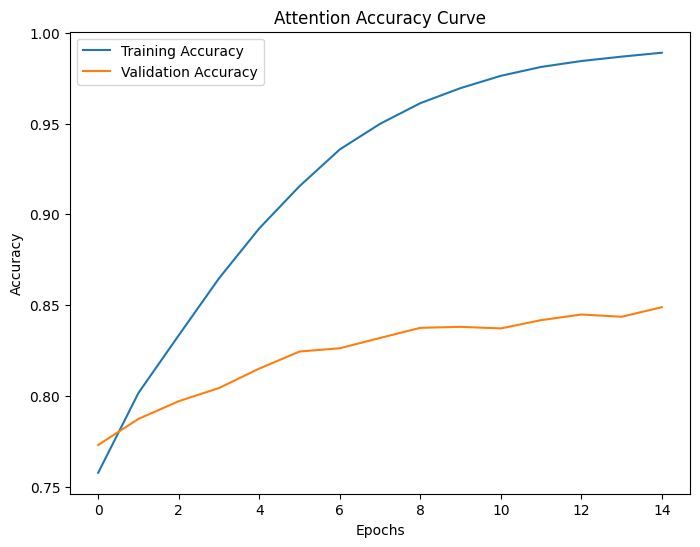

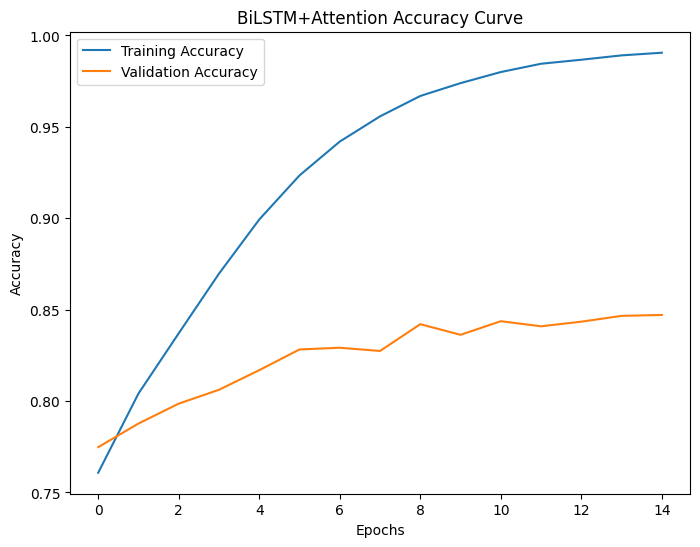

In [80]:
def plot_accuracy_curve(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
     # Set y-axis range from 0 to 1 for accuracy
    plt.show()

# Plot accuracy curves for each model
plot_accuracy_curve(history_rnn, 'RNN Accuracy Curve')
plot_accuracy_curve(history_lstm, 'LSTM Accuracy Curve')
plot_accuracy_curve(history_bilstm, 'BiLSTM Accuracy Curve')
plot_accuracy_curve(history_attention, 'Attention Accuracy Curve')
plot_accuracy_curve(history_bilstm_attention, 'BiLSTM+Attention Accuracy Curve')


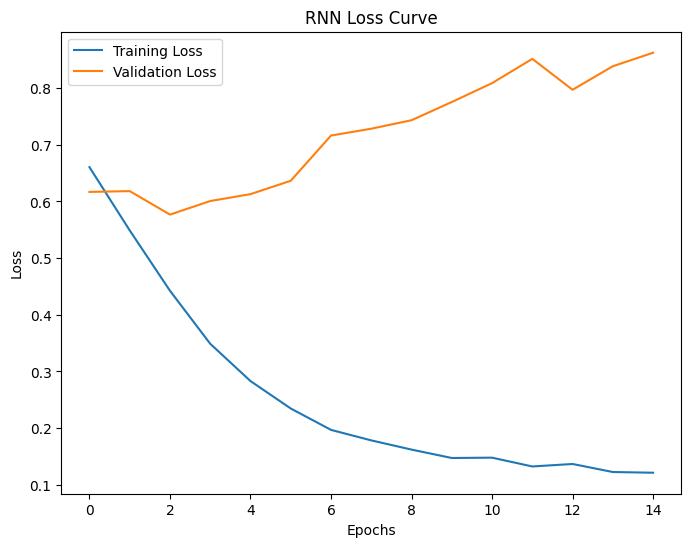

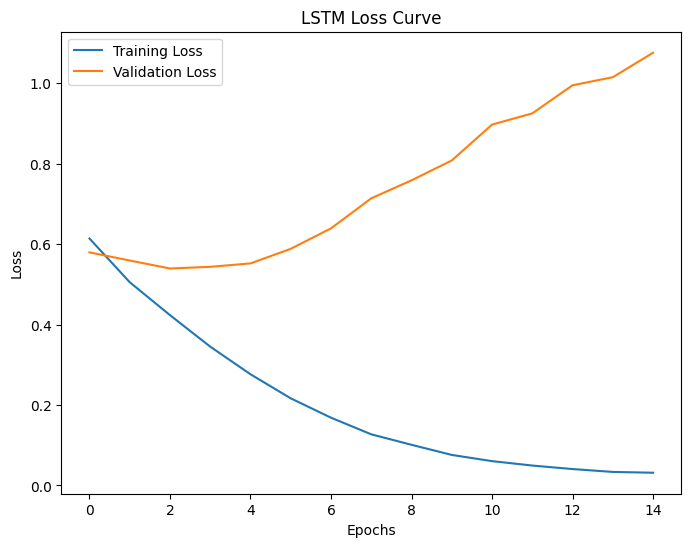

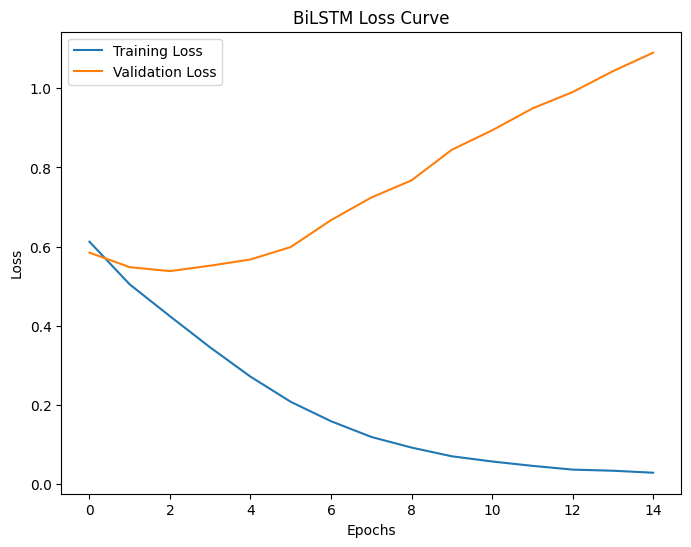

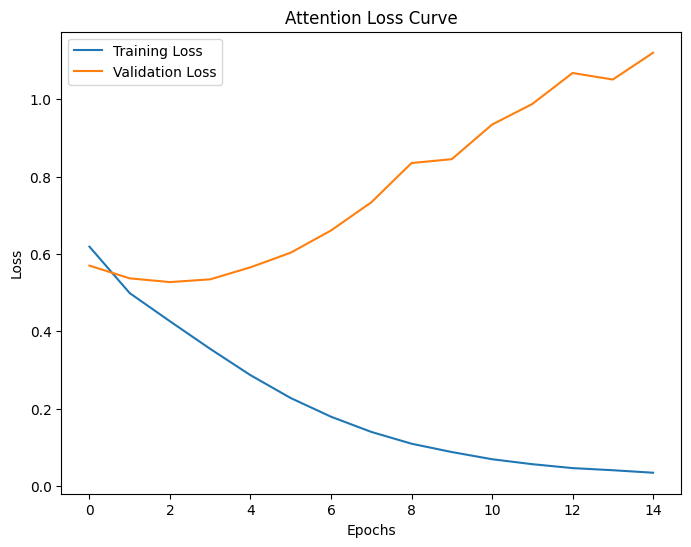

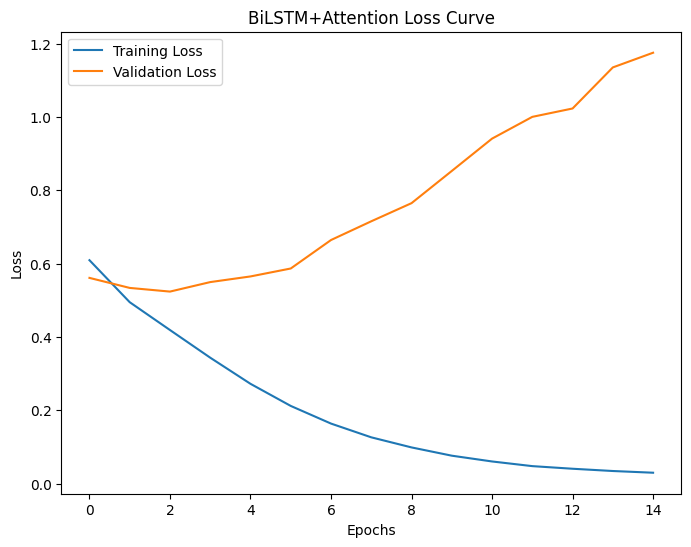

In [76]:

def plot_loss_curve(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_curve(history_rnn, 'RNN Loss Curve')
plot_loss_curve(history_lstm, 'LSTM Loss Curve')
plot_loss_curve(history_bilstm, 'BiLSTM Loss Curve')
plot_loss_curve(history_attention, 'Attention Loss Curve')
plot_loss_curve(history_bilstm_attention, 'BiLSTM+Attention Loss Curve')


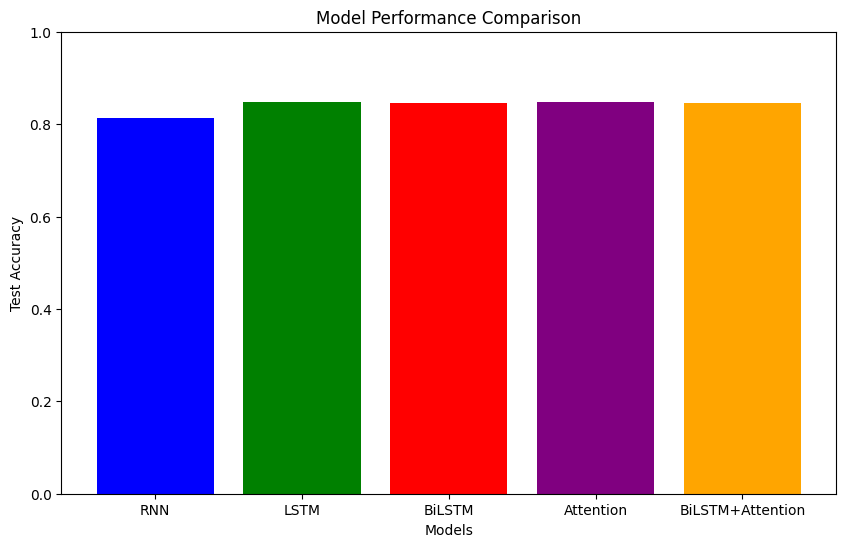

In [78]:
models = ['RNN', 'LSTM', 'BiLSTM', 'Attention', 'BiLSTM+Attention']
test_accuracies = [test_acc_rnn, test_acc_lstm, test_acc_bilstm, test_acc_attention, test_acc_bilstm_att]

plt.figure(figsize=(10, 6))
plt.bar(models, test_accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.show()